# SML reference designs – training a segmentation model in PyTorch

In this notebook we will train a land cover segmentation model using PyTorch. The model will be used for demonstration purposes in the reference deployment procedure for PyTorch users. In your work, you can develop your custom model however you want, as long as it satisfies some deployment requirements and limitations. The following notebook may help you to create a custom model with Vitis AI deployment in mind.

In [1]:
# Force standard (ASCII) tqdm progress bar
import tqdm.notebook
tqdm.notebook.tqdm = tqdm.tqdm

In [2]:
import os
from pathlib import Path

import inspect
import matplotlib as mpl
import pandas as pd
import pytorch_lightning as pl
import torch
from matplotlib import pyplot as plt
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.loggers import CSVLogger
from torch.utils.data import random_split
from torchmetrics.functional.classification.jaccard import jaccard_index
from torchsummary import summary
from segmentation_models_pytorch.losses import JaccardLoss

from sml_tutorials_ml_deployment.datasets import DeepGlobeLandCover, make_classes_legend, normalize_cmap, transforms
from sml_tutorials_ml_deployment.model import Unet
from sml_tutorials_ml_deployment.training import SegmentationTask, make_segmentation_metrics_collection

%config InlineBackend.figure_format = "retina"

In [3]:
# Reproducibility
pl.seed_everything(42)
torch.set_float32_matmul_precision("medium")

Seed set to 42


## Dataset

### Data exploration

In this demo, we are going to train a land cover segmentation model for the [Deep Globe][1] dataset. Since the original dataset comes from an open call challenge with disclosed ground truth test masks, we will utilize a slightly [modified version][2] with different train and test splits. You can download the dataset included in tutorial files or obtain it from [Kaggle][2].

Let's start by loading the dataset and visualizing our segmentation problem.

[1]: http://deepglobe.org
[2]: https://www.kaggle.com/datasets/geoap96/deepglobe2018-landcover-segmentation-traindataset


In [4]:
dataset = DeepGlobeLandCover(Path("../../dataset/deep_globe"), "training")

We can investigate the classes in the dataset.

In [5]:
num_classes = len(dataset.CLASSES)
num_classes

7

In [6]:
dataset.CLASSES

['urban_land',
 'agriculture_land',
 'rangeland',
 'forest_land',
 'water',
 'barren_land',
 'unknown']

Let's take a look at a sample from the dataset. We will investigate the data shape and range to plan the preprocessing pipeline for our data.

In [7]:
demo_sample = dataset[0]
print(f"""
{demo_sample["image"].shape=}, {demo_sample["mask"].shape=},
{demo_sample["image"].dtype=}, {demo_sample["mask"].dtype=},
{demo_sample["image"].min()=}, {demo_sample["image"].max()=},
{demo_sample["mask"].min()=}, {demo_sample["mask"].max()=}
""")


demo_sample["image"].shape=(2448, 2448, 3), demo_sample["mask"].shape=(2448, 2448),
demo_sample["image"].dtype=dtype('uint8'), demo_sample["mask"].dtype=dtype('uint8'),
demo_sample["image"].min()=0, demo_sample["image"].max()=255,
demo_sample["mask"].min()=0, demo_sample["mask"].max()=4



The images are quite large for model training and saved in integer data range. You can also delve into the dataloader source code to understand better how the samples are being loaded. We will take care of data preprocessing later, now lets display a demo sample and take a loook at it.

In [8]:
# Colormap and legend for classes
classes_legend = make_classes_legend(dataset.COLORMAP, dataset.CLASSES)
cmap = mpl.colors.ListedColormap(normalize_cmap(dataset.COLORMAP))

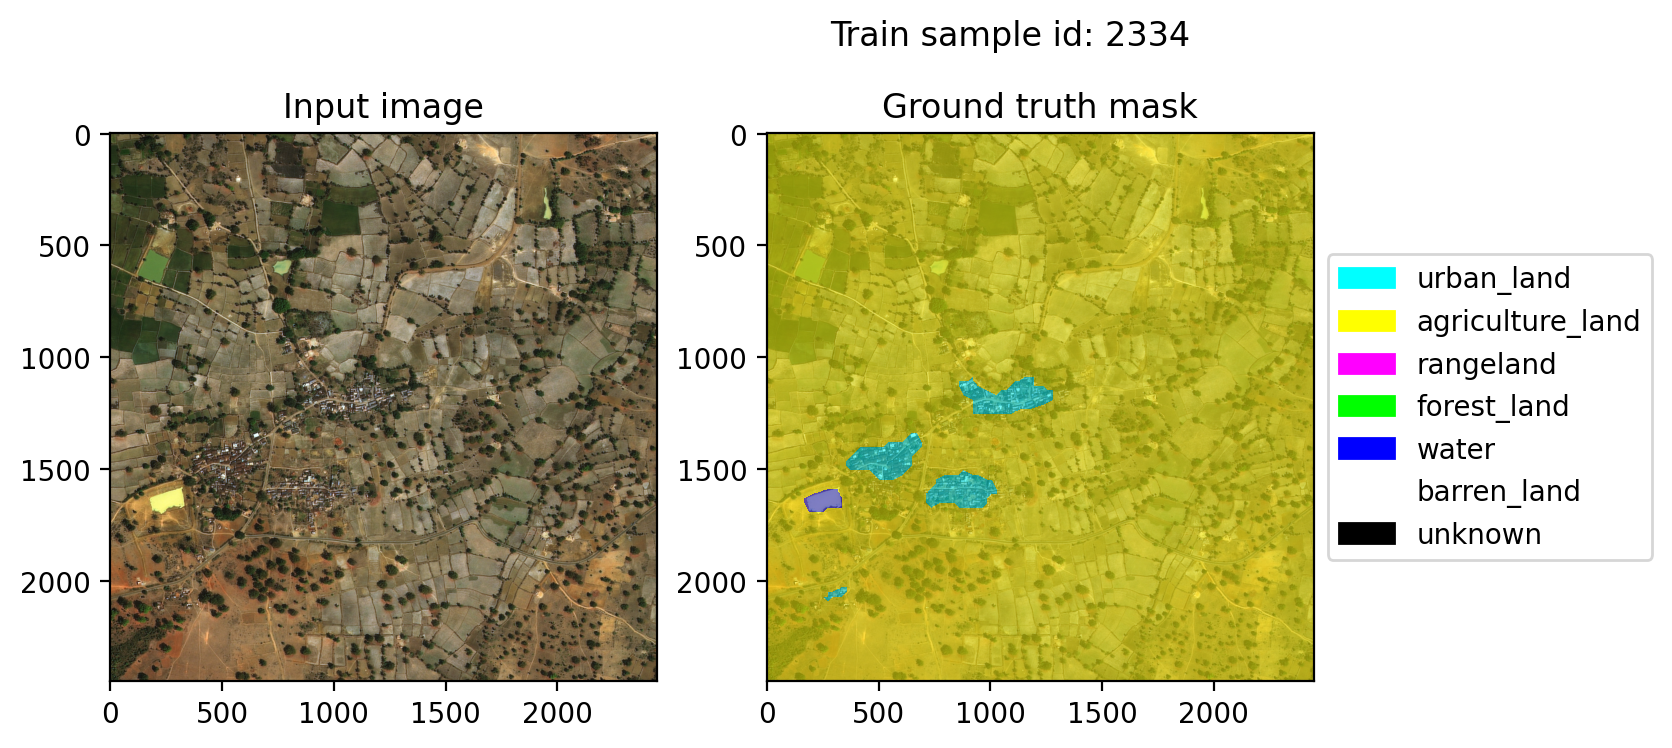

In [9]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.imshow(demo_sample["image"])
plt.title("Input image")

plt.subplot(1, 3, 2)
plt.imshow(demo_sample["image"])
plt.imshow(demo_sample["mask"], alpha=0.5, cmap=cmap, vmin=0, vmax=num_classes, interpolation="nearest")
plt.title("Ground truth mask")

sample_id = demo_sample["id"]
plt.suptitle(f"Train sample id: {sample_id}")
plt.legend(classes_legend, dataset.CLASSES, loc="center left", bbox_to_anchor=(1, 0.5))

plt.show()

### Preparing data for training

Now, we can load the train and test splits from the patched dataset. Remember that the raw data pieces are stored in integer type; we should take care of that with transforms. A default transformation function is provided alongside the dataset loader. We can display its source code to see the necessary preprocessing steps.


In [10]:
print(inspect.getsource(transforms))

def transforms(batch: dict[str, torch.Tensor]) -> dict[str, torch.Tensor]:
    img, mask = batch["image"], batch["mask"]
    batch["image"] = rearrange(torch.as_tensor(img, dtype=torch.float32), "h w c -> c h w") / 255
    batch["mask"] = torch.as_tensor(mask, dtype=torch.long)
    return batch



In [11]:
train_ds = DeepGlobeLandCover(root_dir=Path("../../dataset/deep_globe_patched"), split="training", transforms=transforms)
test_ds = DeepGlobeLandCover(root_dir=Path("../../dataset/deep_globe_patched"), split="test", transforms=transforms)

We can once again load a demo sample and display some information about it to check how the preprocessing works. Let's display the patched image chips in a grid.

In [12]:
demo_sample = train_ds[100]
print(f"""
{demo_sample["image"].shape=}, {demo_sample["mask"].shape=},
{demo_sample["image"].dtype=}, {demo_sample["mask"].dtype=},
{demo_sample["image"].min()=}, {demo_sample["image"].max()=},
{demo_sample["mask"].min()=}, {demo_sample["mask"].max()=}
""")


demo_sample["image"].shape=torch.Size([3, 512, 512]), demo_sample["mask"].shape=torch.Size([512, 512]),
demo_sample["image"].dtype=torch.float32, demo_sample["mask"].dtype=torch.int64,
demo_sample["image"].min()=tensor(0.), demo_sample["image"].max()=tensor(1.),
demo_sample["mask"].min()=tensor(1), demo_sample["mask"].max()=tensor(6)



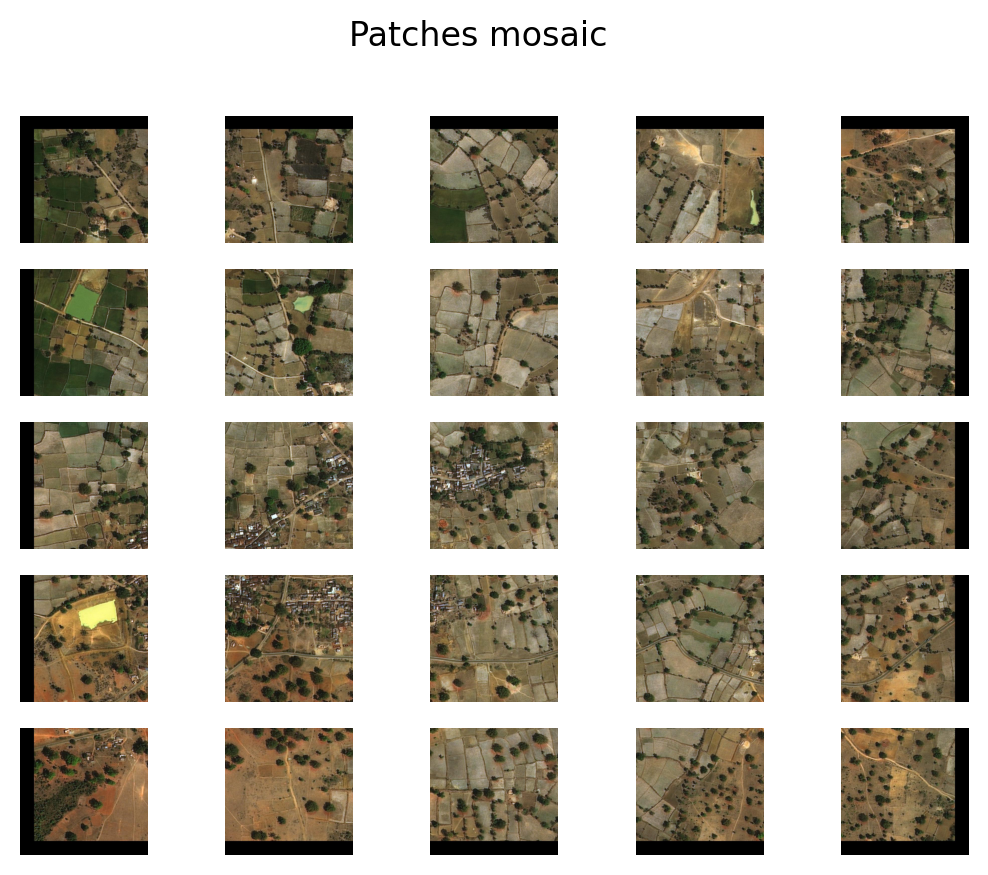

In [13]:
num_patches_per_scene_edge = 5
for i in range(num_patches_per_scene_edge**2):
    plt.subplot(num_patches_per_scene_edge, num_patches_per_scene_edge, i + 1)
    plt.imshow(train_ds[i]["image"].permute(1, 2, 0))
    plt.axis("off")
plt.suptitle("Patches mosaic")
plt.show()

We will create a small validation split for training monitoring purposes.

In [14]:
train_ds, val_ds = random_split(train_ds, [0.85, 0.15])

## Model creation

We have our dataset prepared and can now move on to model development. At this stage, we can create our PyTorch model in a standard way and don't need to use any deployment-related Vitis AI tools for that. However, note that although the model is defined in the conventional PyTorch way, it must be composed of Vitis AI-compatible layers, which can be found in the [Vitis AI documentation][1].

We also advise minimizing 3rd party dependencies in the Python module that contains the model code. Since the model needs to be later imported into the Vitis AI Docker container, it is most convenient to keep it lightweight in terms of dependencies.

For our demo segmentation model, we have chosen the UNet architecture with a ResNet-18 encoder (pretrained on the ImageNet dataset). Feel free to investigate its source code for more insight; here, we will print a short model summary.

[1]: https://docs.amd.com/r/en-US/ug1414-vitis-ai/Operators-Supported-by-PyTorch

In [15]:
model = Unet(num_classes=len(dataset.CLASSES))
summary(model, depth=1, verbose=False)

Layer (type:depth-idx)                   Param #
├─ResNet: 1-1                            11,689,512
├─GraphModuleImpl: 1-2                   11,176,512
├─Decoder: 1-3                           8,658,656
├─Conv2d: 1-4                            231
Total params: 31,524,911
Trainable params: 31,524,911
Non-trainable params: 0

### Model training

Now we can proceed with the model training. In this demo, we will use PyTorch Lightning to speed up the development process.

In [16]:
datamodule = pl.LightningDataModule.from_datasets(train_ds, val_ds, test_ds, batch_size=16, num_workers=8)

In [17]:
metrics = make_segmentation_metrics_collection(num_classes)

In [18]:
task = SegmentationTask(model, loss=JaccardLoss("multiclass"), metrics=metrics, lr=1e-5)

In [19]:
trainer = pl.Trainer(
    max_epochs=150,
    logger=CSVLogger("training_logs"),
    callbacks=[ModelCheckpoint(monitor="val_loss")],
    enable_progress_bar=not os.getenv("SML_DEMO_NO_PROGRESS"),
    deterministic=True,
)

GPU available: True (cuda), used: True


TPU available: False, using: 0 TPU cores


HPU available: False, using: 0 HPUs


In [20]:
trainer.fit(model=task, datamodule=datamodule)

Missing logger folder: training_logs/lightning_logs


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



  | Name    | Type             | Params | Mode 
-----------------------------------------------------
0 | model   | Unet             | 20.3 M | eval 
1 | loss    | JaccardLoss      | 0      | train
2 | metrics | MetricCollection | 0      | train
-----------------------------------------------------
20.3 M    Trainable params
0         Non-trainable params
20.3 M    Total params
81.394    Total estimated model params size (MB)


`Trainer.fit` stopped: `max_epochs=150` reached.


Finally, we can plot the training history.

In [21]:
train_hist = pd.read_csv(Path(trainer.logger.log_dir) / "metrics.csv")

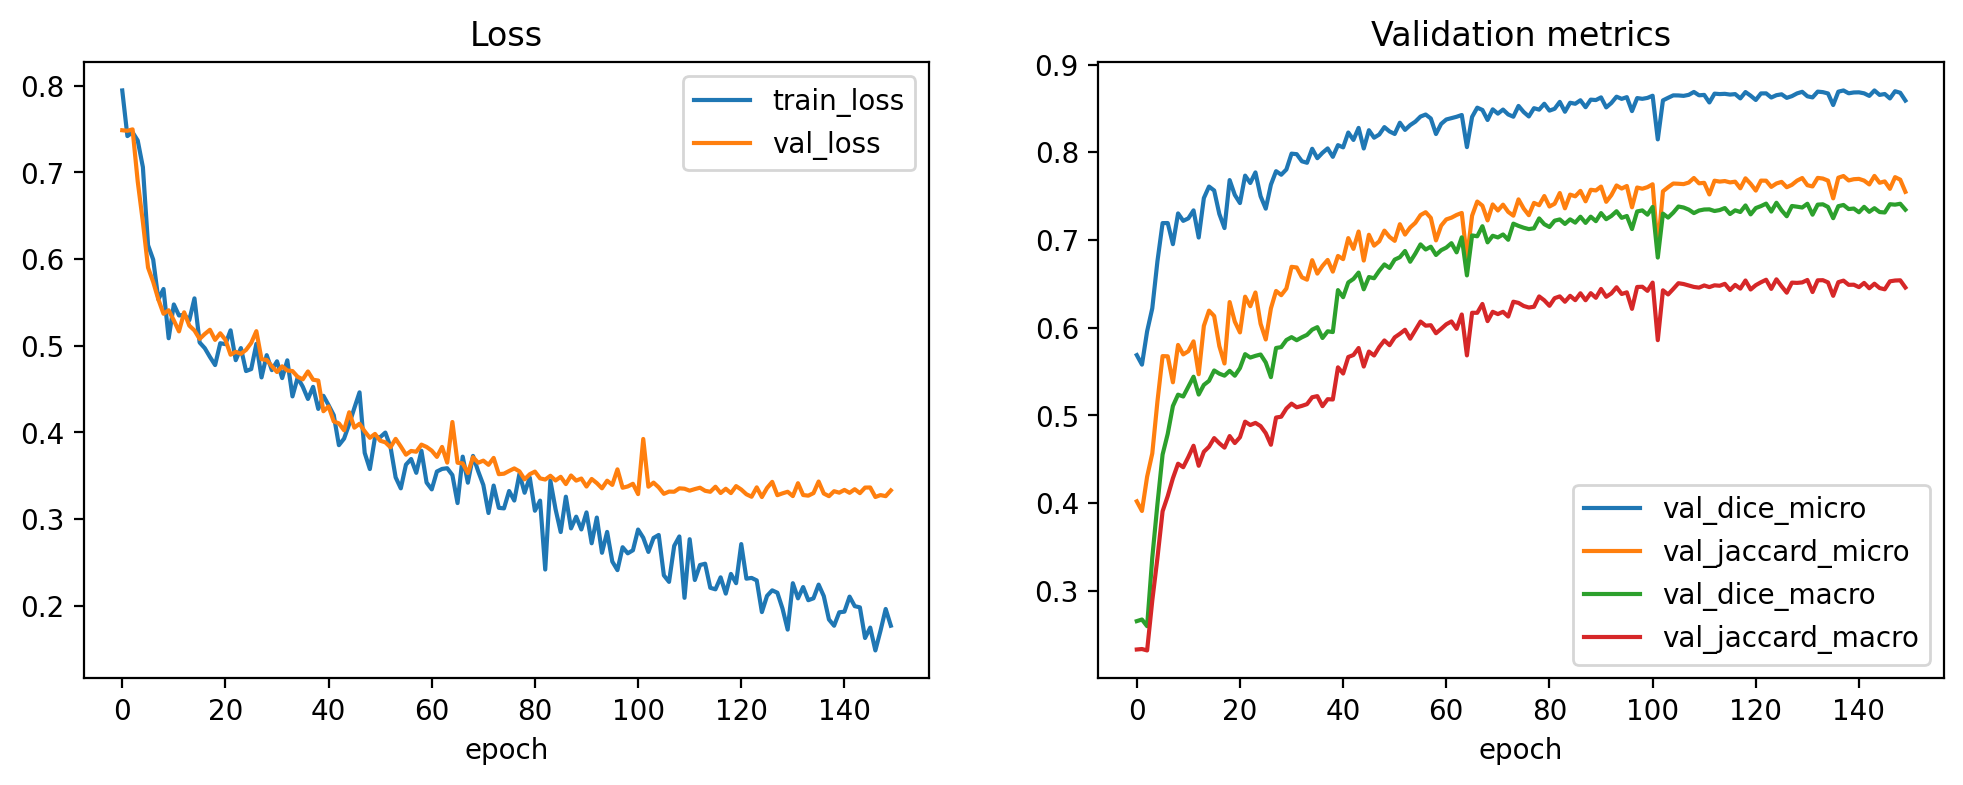

In [22]:
plt.figure(figsize=(12, 4))

ax = plt.subplot(1, 2, 1)
train_hist.dropna(subset=["train_loss"]).groupby("epoch").mean().plot(ax=ax, y="train_loss")
train_hist.dropna(subset=["val_loss"]).plot(ax=ax, x="epoch", y="val_loss")
plt.title("Loss")

ax = plt.subplot(1, 2, 2)
train_hist.dropna(subset=["val_loss"]).plot(ax=ax, x="epoch", y=["val_dice_micro", "val_jaccard_micro", "val_dice_macro", "val_jaccard_macro"])
plt.title("Validation metrics")

plt.show()

The training curves look promising; the losses decrease and the validation metrics improve over epochs.

## Model evaluation

After training the model, let's evaluate it on the test set.

In [23]:
test_metrics = trainer.test(model=task, datamodule=datamodule, ckpt_path="best")

Restoring states from the checkpoint path at training_logs/lightning_logs/version_0/checkpoints/epoch=124-step=113500.ckpt


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Loaded model weights from the checkpoint at training_logs/lightning_logs/version_0/checkpoints/epoch=124-step=113500.ckpt


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      test_dice_macro      │    0.5134307146072388     │
│      test_dice_micro      │    0.8397648334503174     │
│    test_jaccard_macro     │    0.4525362551212311     │
│    test_jaccard_micro     │    0.7364875674247742     │
│         test_loss         │    0.3147698640823364     │
└───────────────────────────┴───────────────────────────┘

Besides quantitive results we can also take a look at prediction preview.

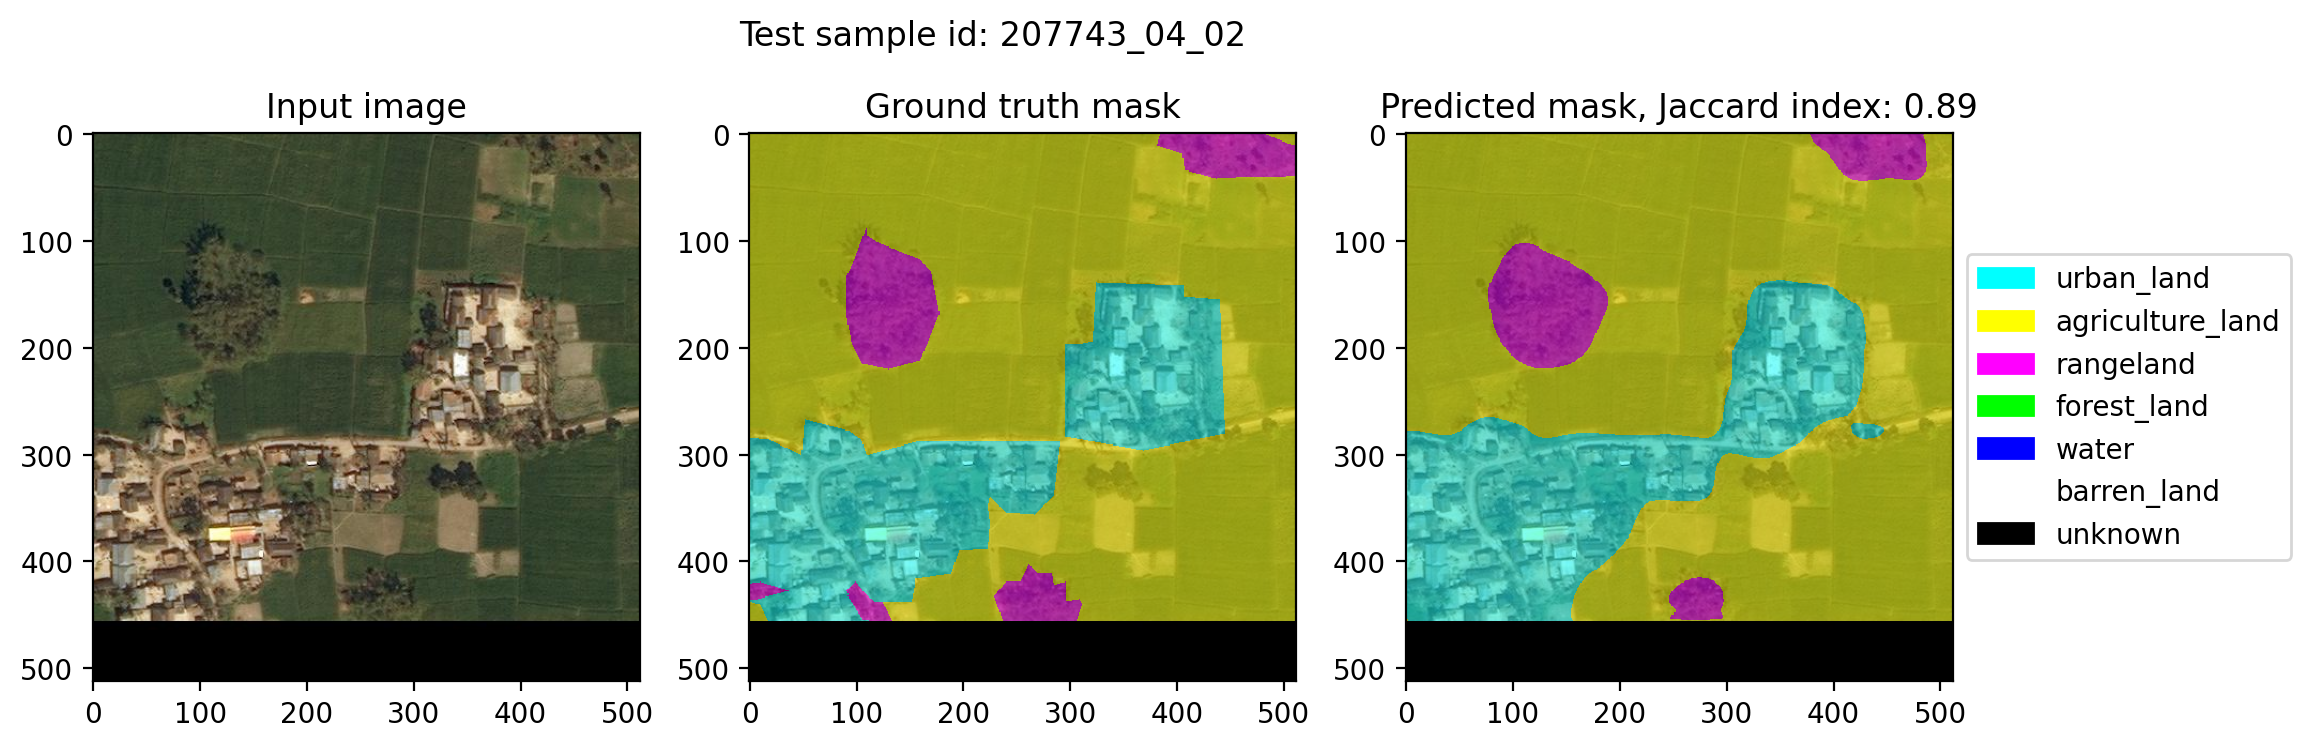

In [24]:
test_sample = test_ds[2472]
test_input = test_sample["image"]
test_mask = test_sample["mask"]

test_batch = test_input.unsqueeze(0)
test_batch = test_batch.to(task.device)
pred_batch = task(test_batch)

pred_sample = pred_batch[0]
pred_sample_cls = pred_sample.argmax(dim=0).long().detach().cpu()

plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.imshow(test_input.permute(1, 2, 0))
plt.title("Input image")

plt.subplot(1, 3, 2)
plt.imshow(test_input.permute(1, 2, 0))
plt.imshow(test_mask, alpha=0.5, cmap=cmap, vmin=0, vmax=num_classes, interpolation="nearest")
plt.title("Ground truth mask")

plt.subplot(1, 3, 3)
plt.imshow(test_input.permute(1, 2, 0))
plt.imshow(pred_sample_cls, alpha=0.5, cmap=cmap, vmin=0, vmax=num_classes, interpolation="nearest")
plt.title("Predicted mask, Jaccard index: {:.2f}".format(jaccard_index(pred_sample_cls, test_mask, task="multiclass", num_classes=num_classes, average="micro")))

plt.suptitle(f"Test sample id: {test_sample["id"]}")
plt.legend(classes_legend, dataset.CLASSES, loc="center left", bbox_to_anchor=(1, 0.5))

plt.show()

It seems that the demo model is working. The training checkpoint and weights are saved in the `training_logs` directory. We will use them in the deployment procedure to run our model on the edge.